### Importing packages
* NPZ: for loading the datasets, which are saved as numpy arrays
* Flux: Library for machine learning (ML) in Julia
* NeuralOperators: for making FNO (Fourier Neural Operator)
* BSON: for saving ML model

In [1]:
using NPZ
using Flux
using Flux.Data
using NeuralOperators
using BSON: @save
using CUDA
using FFTW

using Statistics

In [5]:
# ==================================================
# Input parameters
# ==================================================

device = gpu

num_input = 2
num_output = 4
num_grids_h = 64
num_grids_v = 64
size_cell = 64.0
ids_training = 1:1000
ids_training_info = 1:32
ids_test_info = 4001:4032
num_sample = 5000

# case_study = "PINN_curl" 
case_study = "nonPINN"
# case_study = "PINN"

coef_PDE_loss = 0.01*size_cell

weighted_loss = true
max_weight_loss = 4.0

if case_study == "PINN_curl"
    last_channel = 6
else
    last_channel = 4
end

FNO_channels = [num_input, 30,30,30 ,last_channel]

num_epoch = 100

# ==================================================


100

### Function definition for loading data

* E: Young's Modulus, v: Poison ratio, Pij: stress components (i,j=1,2,3)
* normalize: a function for normalizing data between 0 and 1.

In [3]:
"""
dir: String, the directory address of the data
"""
function load_data(dir)

    E = npzread(dir*"E.npy")
    v = npzread(dir*"v.npy")
    P22 = npzread(dir*"P22.npy")
    P23 = npzread(dir*"P23.npy")
    P32 = npzread(dir*"P32.npy")
    P33 = npzread(dir*"P33.npy")
    
    return E, v, P22, P23, P32, P33
end

function normalize(data; vmin=0.0, vmax=1.0)
    min_data = minimum(data)
    max_data = maximum(data)
    data_n = (data .- min_data)./(max_data-min_data)
    return data_n.*(vmax-vmin) .+ vmin
end

function normalize(data, min_data, max_data; vmin=0.0, vmax=1.0)
    # min_data = minimum(data)
    # max_data = maximum(data)
    data_n = (data .- min_data)./(max_data-min_data)
    return data_n.*(vmax-vmin) .+ vmin
end

function scale_data(data, min_data, max_data)
    return data .*(max_data-min_data) .+ min_data
end


scale_data (generic function with 1 method)

#### Loading Data and normalizing them
* num_input: The number of the input channels for FNO
* num_output: The number of the output channels for FNO
* image_size_x: The image size
* image_size_y: The image size
* num_sample: The number of the samples, which are available in the datasets

In [7]:
dir = "simulation/";
# dir = "../ML_elasticity_julia/"
E, v, P22, P23, P32, P33 = load_data(dir);

min_P22_P23 = minimum([minimum(P22),minimum(P23)]);
max_P22_P23 = maximum([maximum(P22),maximum(P23)]);

min_P32_P33 = minimum([minimum(P32),minimum(P33)]);
max_P32_P33 = maximum([maximum(P32),maximum(P33)]);

@show size(E), size(P33);


input_data = zeros(Float32, num_input, num_grids_h, num_grids_v, num_sample);
output_data = zeros(Float32, num_output, num_grids_h, num_grids_v, num_sample);


input_data[1,:,:,:] .= normalize(E).|>Float32;
input_data[2,:,:,:] .= normalize(v).|>Float32;
output_data[1,:,:,:] .= normalize(P22, min_P22_P23, max_P22_P23).|>Float32;
output_data[2,:,:,:] .= normalize(P23, min_P22_P23, max_P22_P23).|>Float32;
output_data[3,:,:,:] .= normalize(P32, min_P32_P33, max_P32_P33).|>Float32;
output_data[4,:,:,:] .= normalize(P33, min_P32_P33, max_P32_P33).|>Float32;


(size(E), size(P33)) = ((64, 64, 5000), (64, 64, 5000))


In [8]:
function make_FNO(channels; modes=(20,20), activation=gelu, activation_last=Flux.sigmoid)
    num_ch = length(channels)
    m = Flux.Dense(channels[1]=>channels[2], activation)
    # m = OperatorKernel(channels[2]=>channels[3], modes, FourierTransform, activation, permuted=false)
    for ch=2:num_ch-2
        OpKer = OperatorKernel(channels[ch]=>channels[ch+1], modes, FourierTransform, activation, permuted=false)
        m = Chain(m, OpKer)
    end
    m = Chain(m, Flux.Dense(channels[num_ch-1]=>channels[num_ch]), activation_last)
    return m
end


make_FNO (generic function with 1 method)

In [9]:
mutable struct FNO_curl
    FNO::Chain
    k1::AbstractArray
    k2::AbstractArray
end

Flux.@functor FNO_curl

function (m::FNO_curl)(x::AbstractArray)
    size_ = size(x);
    W = size_[2];
    H = size_[3];
    B = size_[4];
    x1 = m.FNO(x);
    x1_ave = sum(x1, dims=[2,3])/(W*H);
    Ax = x1[1,:,:,:] .- x1_ave[1,:,:,:];
    Ay = x1_ave[2,1,1,:];
    Az = x1_ave[3,1,1,:];
    Axh = CUFFT.fft(Ax, [1,2]);
    P1_f = CUFFT.ifft(-Axh.*m.k2, [1,2])|>real;
    P2_f = CUFFT.ifft(Axh.*m.k1, [1,2])|>real;
    P1 = P1_f .+ Ay[[CartesianIndex()],[CartesianIndex()],:]
    P2 = P2_f .+ Az[[CartesianIndex()],[CartesianIndex()],:]
    Ax = x1[4,:,:,:] .- x1_ave[4,:,:,:];
    Ay = x1_ave[5,1,1,:];
    Az = x1_ave[6,1,1,:];
    Axh = CUFFT.fft(Ax, [1,2]);
    P3_f = CUFFT.ifft(-Axh.*m.k2, [1,2])|>real;
    P4_f = CUFFT.ifft(Axh.*m.k1, [1,2])|>real;
    P3 = P3_f .+ Ay[[CartesianIndex()],[CartesianIndex()],:]
    P4 = P4_f .+ Az[[CartesianIndex()],[CartesianIndex()],:]
    # cat(reshape(P1, 1,W,H,B), reshape(P2, 1,W,H,B), dims=1)
    # cat(reshape(P1, 1,W,H,B), reshape(P2, 1,W,H,B), reshape(P3, 1,W,H,B), reshape(P4, 1,W,H,B), dims=1)
    return cat(reshape(P1, 1,W,H,B), reshape(P2, 1,W,H,B), reshape(P3, 1,W,H,B), reshape(P4, 1,W,H,B), dims=1)
end


In [10]:

function get_fft_freq(img_size_h, img_size_v, L, device)
    
    n1 = img_size_h
    n2 = img_size_v

    Nyquist_freq = Int(n1/2)+1

    k1_1d = Float32.(fftfreq(n1))*n1;
    k2_1d = Float32.(fftfreq(n2))*n2;
    coeff = ComplexF32(2pi*im/L);

    if mod(n1,2)==0
        Nyquist_freq = Int(n1/2)+1
        k1_1d[Nyquist_freq] = 0.0
    end
    
    if mod(n2,2)==0
        Nyquist_freq = Int(n2/2)+1
        k2_1d[Nyquist_freq] = 0.0
    end

    k1 = coeff*[k1_1d[i] for i=1:n1, j=1:n2]|>device;
    k2 = coeff*[k2_1d[j] for i=1:n1, j=1:n2]|>device;

    return k1, k2
end

function calc_div(V1, V2,k1,k2)
    return CUFFT.ifft(CUFFT.fft(V1).*k1 + CUFFT.fft(V2).*k2)|>real
end


calc_div (generic function with 1 method)

In [14]:
if case_study == "nonPINN"

    model = device(make_FNO(FNO_channels, modes=(64,64), activation=Flux.gelu, activation_last=Flux.sigmoid));
    parameters = Flux.params(model);

elseif case_study == "PINN_curl"

    L = num_grids_h;
    k1, k2 = get_fft_freq(num_grids_h, num_grids_v, size_cell, device);
    model_FNO = device(make_FNO(FNO_channels, modes=(64,64), activation=Flux.gelu, activation_last=Flux.gelu));
    model = FNO_curl(model_FNO, k1, k2)|>device;
    parameters = Flux.params(model.FNO);

elseif case_study == "PINN"

    model = device(make_FNO(FNO_channels, modes=(64,64), activation=Flux.gelu, activation_last=Flux.sigmoid));
    parameters = Flux.params(model);

end

@show model

model = Chain(Chain(Chain(Dense(2 => 30, gelu), OperatorKernel(30 => 30, (64, 64), FourierTransform, σ=gelu, permuted=false)), OperatorKernel(30 => 30, (64, 64), FourierTransform, σ=gelu, permuted=false)), Dense(30 => 4), σ)


Chain(
  Chain(
    Chain(
      Dense(2 => 30, gelu),             # 90 parameters
      OperatorKernel(
        Dense(30 => 30),                # 930 parameters
        OperatorConv(30 => 30, (64, 64), FourierTransform, permuted=false),  # 3_686_400 parameters
        NNlib.gelu,
      ),
    ),
    OperatorKernel(
      Dense(30 => 30),                  # 930 parameters
      OperatorConv(30 => 30, (64, 64), FourierTransform, permuted=false),  # 3_686_400 parameters
      NNlib.gelu,
    ),
  ),
  Dense(30 => 4),                       # 124 parameters
  NNlib.σ,
)                   # Total: 10 arrays, 7_374_874 parameters, 2.094 KiB.

In [15]:
function norm_grad(A, k1, k2)

    Ah = CUFFT.fft(A,[2,3])
    dA_dx = similar(A)
    dA_dy = similar(A)

    for i=1:num_output
        dA_dx[i,:,:,:] .= CUFFT.ifft(Ah[i,:,:,:].*k1, [1,2])|>real
        dA_dy[i,:,:,:] .= CUFFT.ifft(Ah[i,:,:,:].*k2, [1,2])|>real
    end
    
    return sqrt.(dA_dx.*dA_dx + dA_dy.*dA_dy)
end


norm_grad (generic function with 1 method)

In [20]:
if weighted_loss

    k1, k2 = get_fft_freq(num_grids_h, num_grids_v, size_cell, cpu);
    norm_grad_P = norm_grad(output_data, k1, k2);
    weight_loss = normalize(norm_grad_P; vmin=1.0, vmax=max_weight_loss).|>Float32;

    if case_study=="PINN"
        k1, k2 = get_fft_freq(num_grids_h, num_grids_v, size_cell, device);
        function loss_data_PDE_w(x,y,w)
            yp = model(x)
            # loss_data = Flux.mae(yp,y)
            loss_data = mean(w.*abs.(yp-y))
            P1h = CUFFT.fft(yp[1,:,:,:], [1,2])
            P2h = CUFFT.fft(yp[2,:,:,:], [1,2])
            P3h = CUFFT.fft(yp[3,:,:,:], [1,2])
            P4h = CUFFT.fft(yp[4,:,:,:], [1,2])
            loss_divP = CUFFT.ifft(P1h.*k1 + P2h.*k2 + P3h.*k1 + P4h.*k2, [1,2])|>real # size:64
            return loss_data + coef_PDE_loss * sum(abs2, loss_divP) # coeffs: 1,1 ???
        end
        loss(x,y,w) = loss_data_PDE_w(x,y,w)
    else
        loss(x,y,w) = mean(w.*abs.(model(x)-y))
    end

    loader_train = DataLoader((input_data[:,:,:,ids_training], output_data[:,:,:,ids_training],
    weight_loss[:,:,:,ids_training]), batchsize=32, shuffle=true);

    # To warm up gradient calculation 
    Flux.gradient(()->loss(device(input_data[:,:,:,1:2]), device(output_data[:,:,:,1:2]), 
    device(weight_loss[:,:,:,1:2])), parameters);

    function callBack()
        train_loss = loss(input_data[:,:,:,ids_training_info]|>device, 
        output_data[:,:,:,ids_training_info]|>device, weight_loss[:,:,:,ids_training_info]|>device);

        test_loss = loss(input_data[:,:,:,ids_test_info]|>device,
        output_data[:,:,:,ids_test_info]|>device, weight_loss[:,:,:,ids_test_info]|>device);

        return train_loss, test_loss
    end

    model_name = "models/model_test_"*case_study * "_w="*string(max_weight_loss)

else

    if case_study=="PINN"
        k1, k2 = get_fft_freq(num_grids_h, num_grids_v, size_cell, device);
        function loss_data_PDE_w(x,y)
            yp = model(x)
            # loss_data = Flux.mae(yp,y)
            loss_data = mean(abs.(yp-y))
            P1h = CUFFT.fft(yp[1,:,:,:], [1,2])
            P2h = CUFFT.fft(yp[2,:,:,:], [1,2])
            P3h = CUFFT.fft(yp[3,:,:,:], [1,2])
            P4h = CUFFT.fft(yp[4,:,:,:], [1,2])
            loss_divP = CUFFT.ifft(P1h.*k1 + P2h.*k2 + P3h.*k1 + P4h.*k2, [1,2])|>real # size:64
            return loss_data + coef_PDE_loss * sum(abs2, loss_divP) # coeffs: 1,1 ???
        end
        loss(x,y) = loss_data_PDE_w(x,y)
    else
        loss(x,y) = mean(abs.(model(x)-y))
    end

    loader_train = DataLoader((input_data[:,:,:,ids_training], output_data[:,:,:,ids_training]), batchsize=32, shuffle=true);

    Flux.gradient(()->loss(device(input_data[:,:,:,1:2]), device(output_data[:,:,:,1:2])), parameters);

    function callBack()
        train_loss = loss(input_data[:,:,:,ids_training_info]|>device, output_data[:,:,:,ids_training_info]|>device);
        test_loss = loss(input_data[:,:,:,ids_test_info]|>device, output_data[:,:,:,ids_test_info]|>device);
        return train_loss, test_loss
    end

    model_name = "models/model_"*case_study

end


"models/model_test_nonPINN_w=4.0"

In [18]:
# opt = Flux.AdamW(0.001, (0.89, 0.995), 0.1)
optimizer = Flux.ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [21]:
logfile_name = model_name*"_log.txt"
log_file = open(logfile_name, "w")

for epoch in 1:num_epoch

    @show epoch;

    for data_batch in loader_train
        # x, y = device(xtrain_batch), device(ytrain_batch)
        data_device = device(data_batch)
        gradients = Flux.gradient(() -> loss(data_device...), parameters)
        Flux.Optimise.update!(optimizer, parameters, gradients)
    end

    train_loss, test_loss = callBack();

    @info "training loss: $(train_loss)\n"
    @info "test loss: $(test_loss)\n"

    write(log_file, string(train_loss)*", "*string(test_loss)*"\n")

end

close(log_file)


epoch = 1


epoch = 2


┌ Info: training loss: 0.06549481
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0640496
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 3


┌ Info: training loss: 0.021286914
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.020951819
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 4


┌ Info: training loss: 0.016627338
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.016895002
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 5


┌ Info: training loss: 0.01414972
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.014373027
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 6


┌ Info: training loss: 0.012172412
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.012430249
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 7


┌ Info: training loss: 0.010426574
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0107634645
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 8


┌ Info: training loss: 0.008342275
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.008546536
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 9


┌ Info: training loss: 0.0067525767
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0065363036
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 10


┌ Info: training loss: 0.005815179
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0056476677
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 11


┌ Info: training loss: 0.0052788723
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.005191265
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 12


┌ Info: training loss: 0.0049140677
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0048787175
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 13


┌ Info: training loss: 0.004636688
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.004595108
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 14


┌ Info: training loss: 0.0042528445
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.004204691
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 15


┌ Info: training loss: 0.0042444197
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.004232177
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 16


┌ Info: training loss: 0.003785113
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.00383378
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 17


┌ Info: training loss: 0.0035848767
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0036669539
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 18


┌ Info: training loss: 0.0034686825
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0035331892
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 19


┌ Info: training loss: 0.0033265646
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0034838852
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 20


┌ Info: training loss: 0.0031967408
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0033398955
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 21


┌ Info: training loss: 0.0030324175
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.003202565
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 22


┌ Info: training loss: 0.0029323818
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0030919944
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 23


┌ Info: training loss: 0.0028103678
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0029672754
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 24


┌ Info: training loss: 0.0028481423
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0030174232
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 25


┌ Info: training loss: 0.002652911
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.002819418
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 26


┌ Info: training loss: 0.0026308657
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0028024276
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 27


┌ Info: training loss: 0.002514126
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0026811738
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 28


┌ Info: training loss: 0.0025248497
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0026428592
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 29


┌ Info: training loss: 0.002497016
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.002668733
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 30


┌ Info: training loss: 0.0023982106
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0025499049
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 31


┌ Info: training loss: 0.0024502925
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0025496983
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 32


┌ Info: training loss: 0.0023418632
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.002478796
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 33


┌ Info: training loss: 0.002345989
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0024688935
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 34


┌ Info: training loss: 0.0022541918
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0023833762
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 35


┌ Info: training loss: 0.0022929157
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0024109154
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 36


┌ Info: training loss: 0.0023337994
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0023918678
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 37


┌ Info: training loss: 0.0022215522
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0023729312
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 38


┌ Info: training loss: 0.00218054
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.002290481
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 39


┌ Info: training loss: 0.002114557
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0022287564
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 40


┌ Info: training loss: 0.0021281063
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.002200829
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 41


┌ Info: training loss: 0.002072196
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0021705693
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 42


┌ Info: training loss: 0.0021889529
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0022156597
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 43


┌ Info: training loss: 0.0020848336
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0022082336
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 44


┌ Info: training loss: 0.0019845408
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0020730589
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 45


┌ Info: training loss: 0.0021607736
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0022529126
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 46


┌ Info: training loss: 0.0020401273
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0021660675
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 47


┌ Info: training loss: 0.0019335465
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0019971493
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 48


┌ Info: training loss: 0.0019187848
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0020491243
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 49


┌ Info: training loss: 0.0019767687
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.002075325
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 50


┌ Info: training loss: 0.0018846521
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.001975363
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 51


┌ Info: training loss: 0.0018715551
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0019595516
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 52


┌ Info: training loss: 0.0018588658
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0019471841
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 53


┌ Info: training loss: 0.0019565038
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0020221246
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 54


┌ Info: training loss: 0.001811467
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0019190807
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 55


┌ Info: training loss: 0.0018002766
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0018842411
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 56


┌ Info: training loss: 0.0017614001
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.001865126
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 57


┌ Info: training loss: 0.0017718871
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0018448175
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 58


┌ Info: training loss: 0.0018415166
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0019536354
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 59


┌ Info: training loss: 0.0017665697
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0018349261
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 60


┌ Info: training loss: 0.0018027395
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0018673993
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 61


┌ Info: training loss: 0.0016860085
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017974016
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 62


┌ Info: training loss: 0.0018154376
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0019161089
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 63


┌ Info: training loss: 0.0017667867
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0018651022
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 64


┌ Info: training loss: 0.0016653624
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017675073
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 65


┌ Info: training loss: 0.0017264468
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0018156457
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 66


┌ Info: training loss: 0.0016471744
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017662016
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 67


┌ Info: training loss: 0.0016719238
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017273268
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 68


┌ Info: training loss: 0.0016299034
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017078203
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 69


┌ Info: training loss: 0.0016781355
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0018056037
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 70


┌ Info: training loss: 0.0016290306
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017161752
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 71


┌ Info: training loss: 0.0019379782
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0019524854
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 72


┌ Info: training loss: 0.0015954827
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016774854
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 73


┌ Info: training loss: 0.0016452491
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017461518
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 74


┌ Info: training loss: 0.0015714845
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016816625
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 75


┌ Info: training loss: 0.001643342
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017564208
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 76


┌ Info: training loss: 0.0015639309
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016595182
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 77


┌ Info: training loss: 0.0016004032
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016908696
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 78


┌ Info: training loss: 0.0015487153
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016567076
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 79


┌ Info: training loss: 0.001671357
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.001732757
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 80


┌ Info: training loss: 0.0016651957
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017571526
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 81


┌ Info: training loss: 0.0015851288
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017057508
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 82


┌ Info: training loss: 0.0015790911
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016820884
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 83


┌ Info: training loss: 0.0015243633
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016241437
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 84


┌ Info: training loss: 0.0015136882
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016419776
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 85


┌ Info: training loss: 0.0015099413
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.001627632
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 86


┌ Info: training loss: 0.0015053586
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.001622848
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 87


┌ Info: training loss: 0.0015552487
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016811169
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 88


┌ Info: training loss: 0.0020133085
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0020820573
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 89


┌ Info: training loss: 0.0020837034
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0021261813
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 90


┌ Info: training loss: 0.0016787539
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0017650345
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 91


┌ Info: training loss: 0.0014952337
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0015875084
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 92


┌ Info: training loss: 0.0014964002
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.001605479
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 93


┌ Info: training loss: 0.0014391193
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0015631584
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 94


┌ Info: training loss: 0.0014570057
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0015396453
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 95


┌ Info: training loss: 0.0014414641
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.00157331
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 96


┌ Info: training loss: 0.0015204251
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0016273474
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 97


┌ Info: training loss: 0.0014801408
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0015596724
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 98


┌ Info: training loss: 0.0014119169
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0015317886
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 99


┌ Info: training loss: 0.0014188886
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0015598015
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


epoch = 100


┌ Info: training loss: 0.0014088419
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.0014968303
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


┌ Info: training loss: 0.0014494222
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:17
┌ Info: test loss: 0.001542331
└ @ Main /nethome/m.khorrami/files/ML_elasticity_v2/main_training.ipynb:18


In [22]:
model_cpu = cpu(model)
@save model_name*".bson" model_cpu


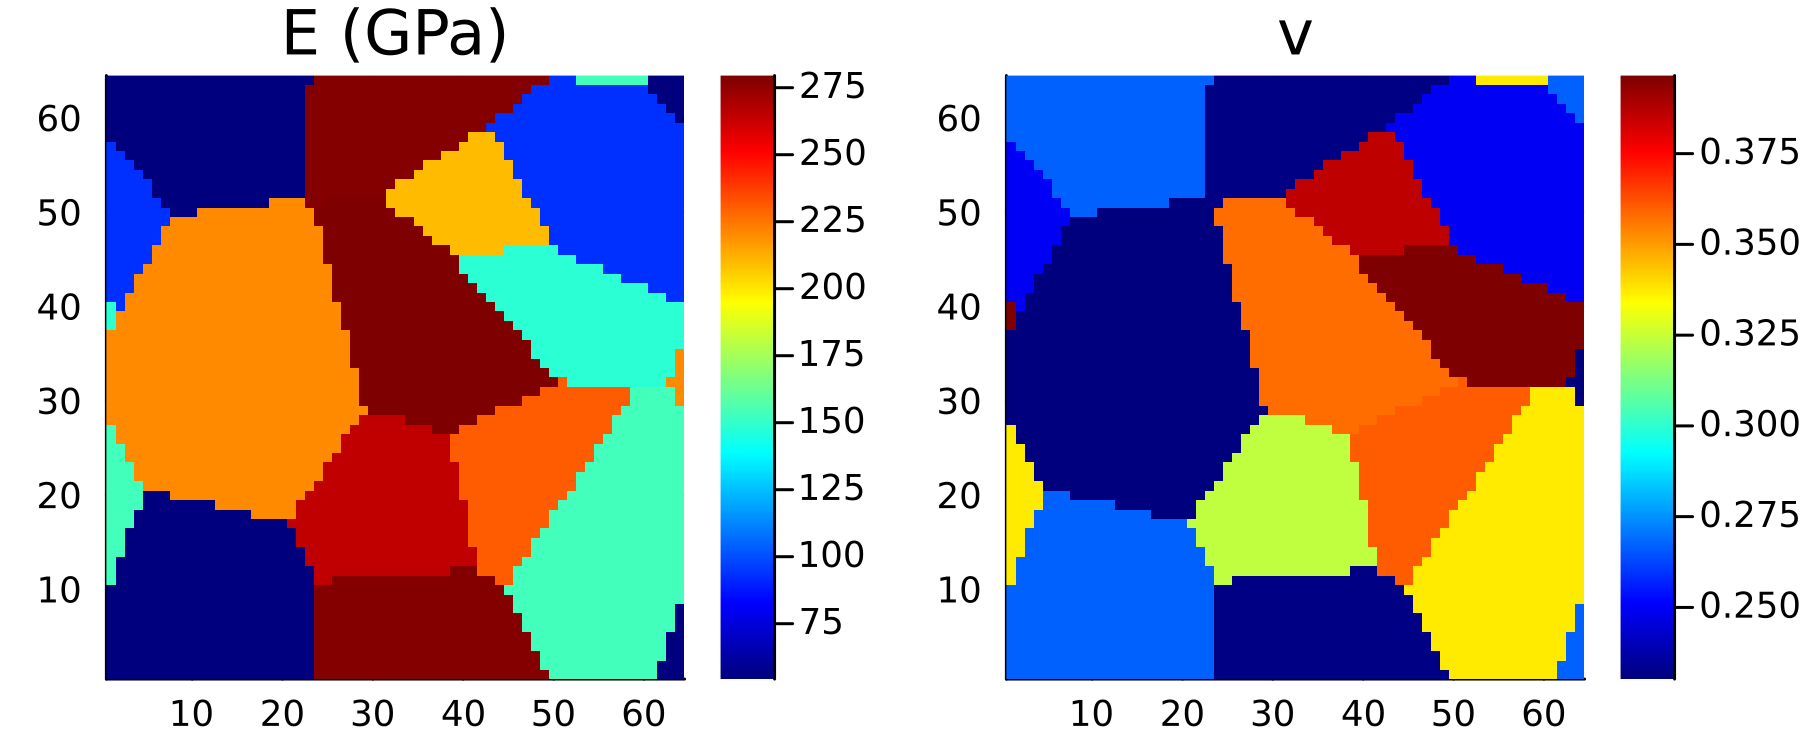

In [27]:
using Plots

id_case = 1
h1 = heatmap(E[:,:,id_case]*1e-9, title="E (GPa)", c=:jet)
h2 = heatmap(v[:,:,id_case], title="v", c=:jet)
plot(h1,h2; dpi=300, size=(600,250))


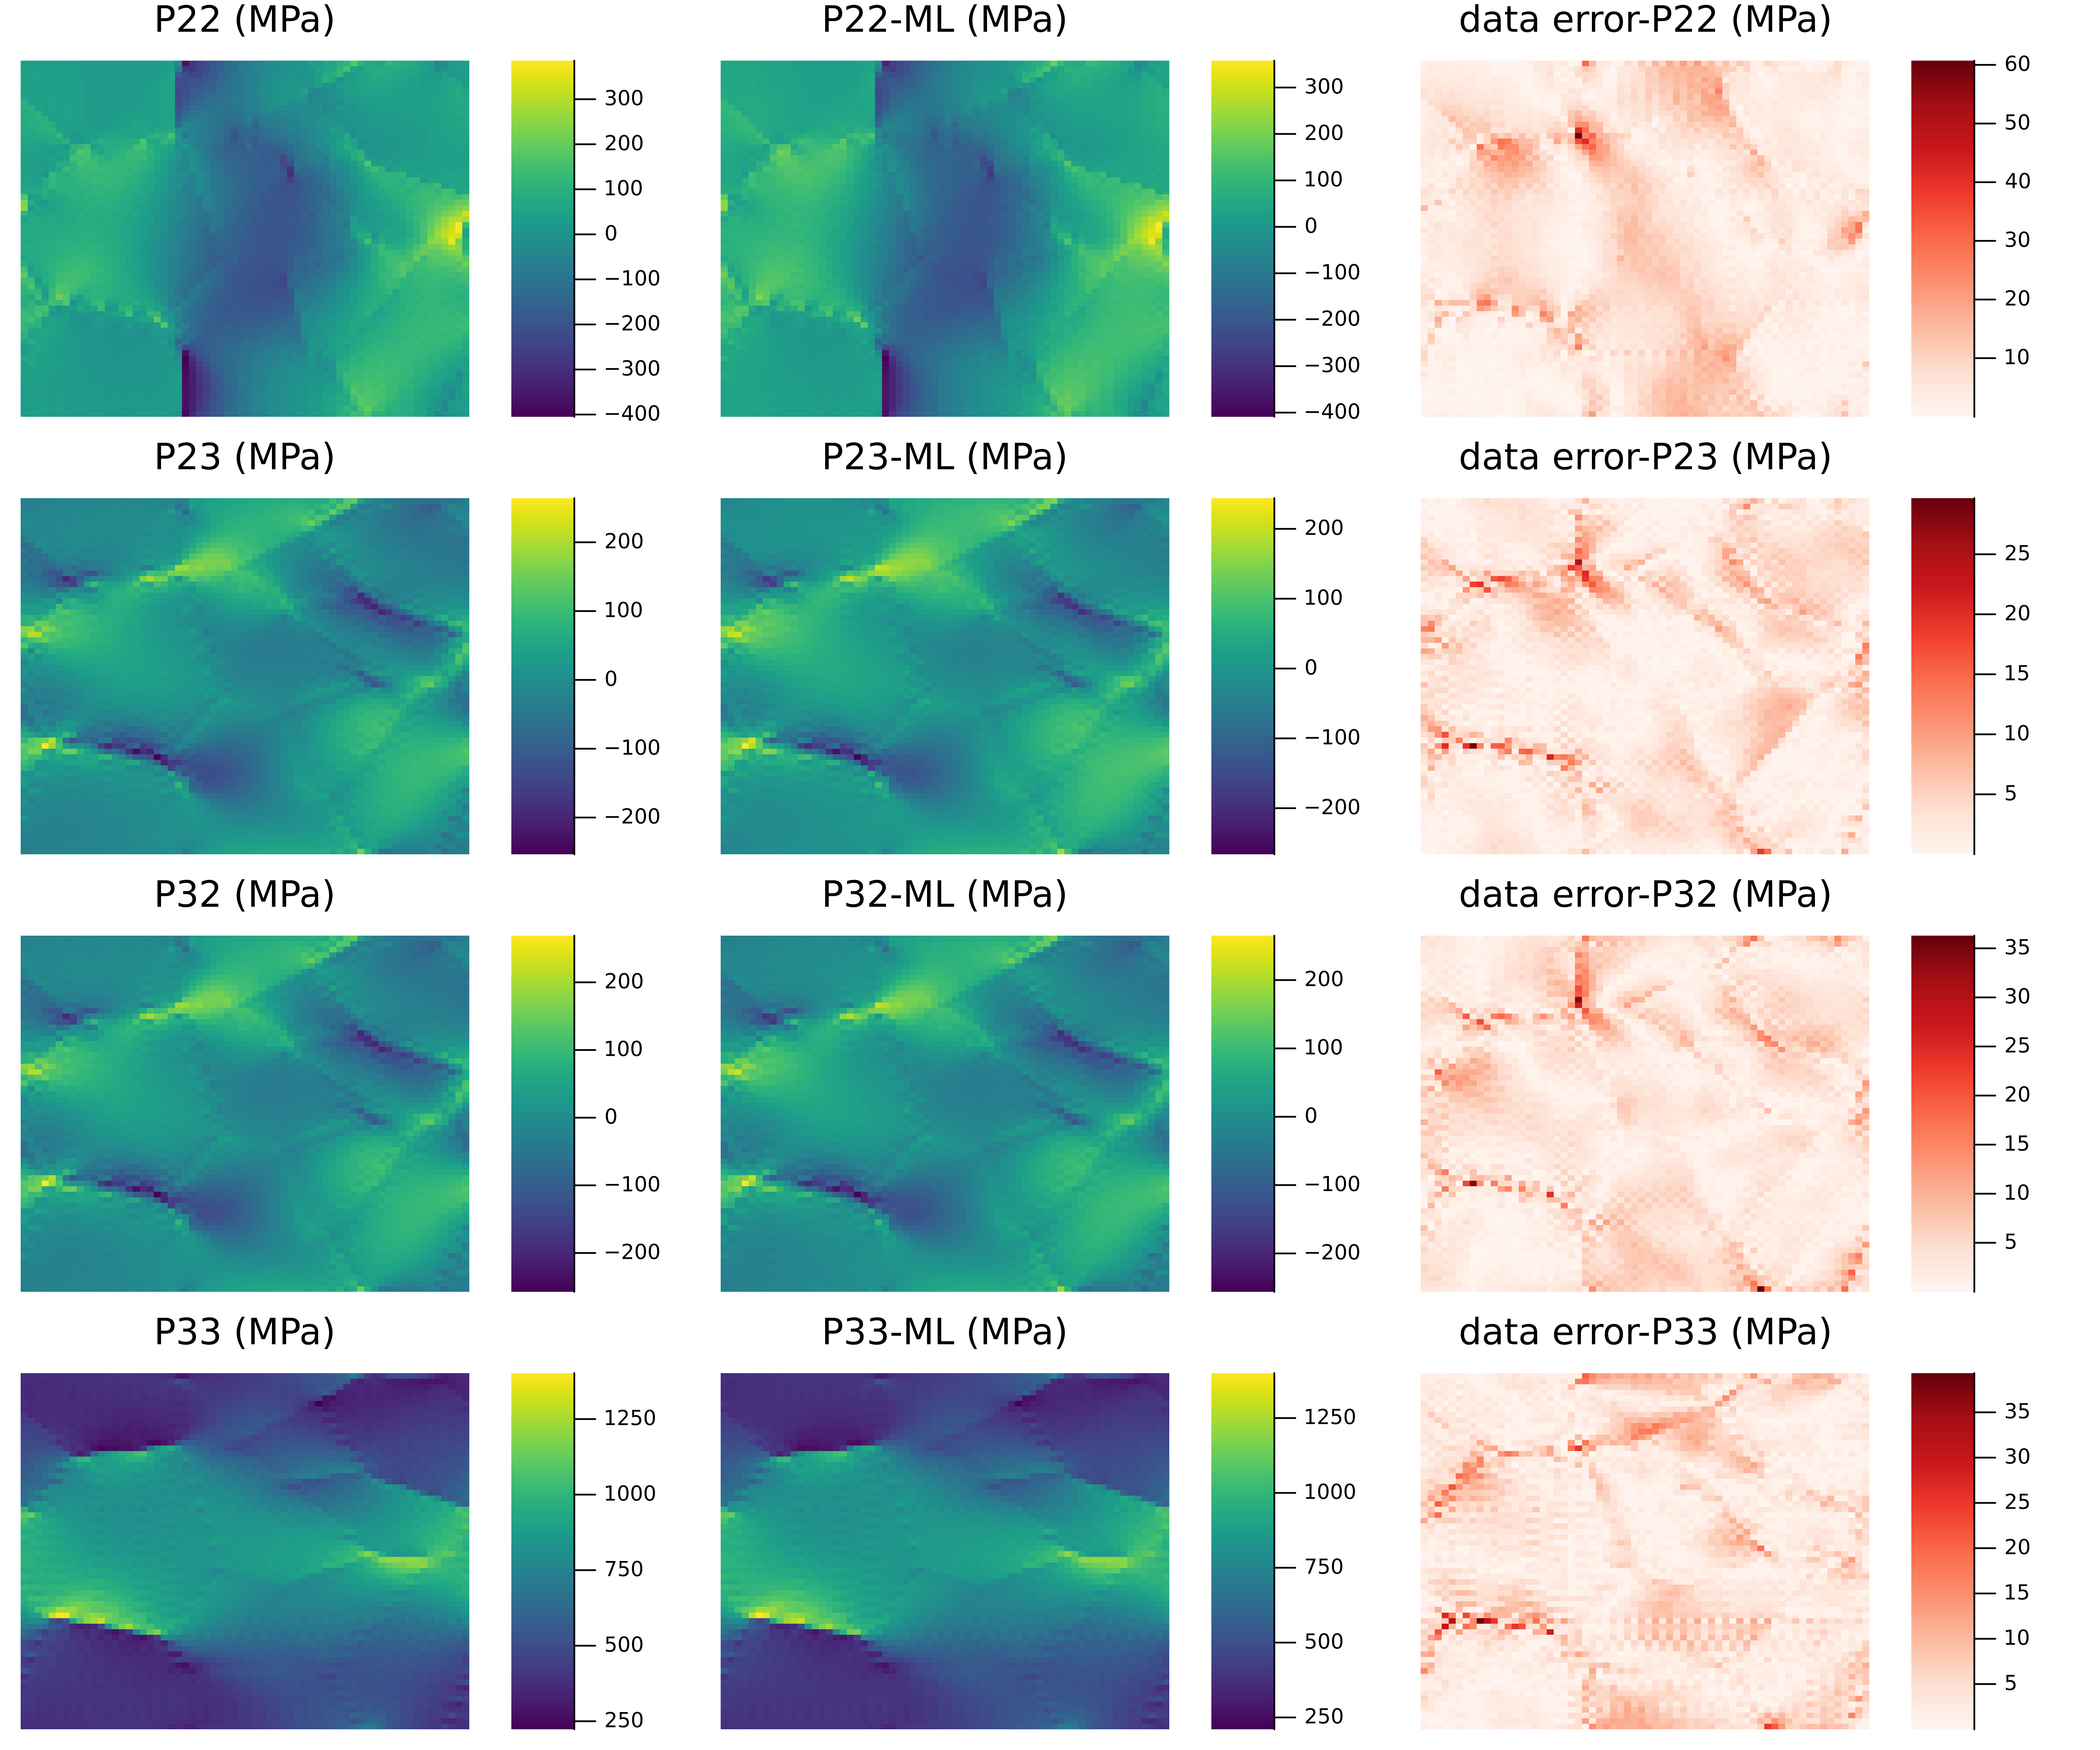

In [29]:

output_FNO = model(input_data[:,:,:,id_case,[CartesianIndex()]]|>device);

P_temp = P22[:,:, id_case]*1e-6;
h4 = heatmap(P_temp, c=:viridis, title="P22 (MPa)")
P_temp_ML = scale_data(output_FNO[1,:,:,id_case]|>cpu, min_P22_P23*1e-6, max_P22_P23*1e-6);
h5 = heatmap(P_temp_ML, c=:viridis, title="P22-ML (MPa)")
h6 = heatmap(abs.(P_temp.-P_temp_ML), c=:Reds, title="data error-P22 (MPa)")
P_temp = P23[:,:, id_case]*1e-6;
h7 = heatmap(P_temp, c=:viridis, title="P23 (MPa)")
P_temp_ML = scale_data(output_FNO[2,:,:,id_case]|>cpu, min_P22_P23*1e-6, max_P22_P23*1e-6);
h8 = heatmap(P_temp_ML, c=:viridis, title="P23-ML (MPa)")
h9 = heatmap(abs.(P_temp.-P_temp_ML), c=:Reds, title="data error-P23 (MPa)")

P_temp = P32[:,:, id_case]*1e-6;
h10 = heatmap(P_temp, c=:viridis, title="P32 (MPa)")
P_temp_ML = scale_data(output_FNO[3,:,:,id_case]|>cpu, min_P32_P33*1e-6, max_P32_P33*1e-6);
h11 = heatmap(P_temp_ML, c=:viridis, title="P32-ML (MPa)")
h12 = heatmap(abs.(P_temp.-P_temp_ML), c=:Reds, title="data error-P32 (MPa)")
P_temp = P33[:,:, id_case]*1e-6;
h13 = heatmap(P_temp, c=:viridis, title="P33 (MPa)")
P_temp_ML = scale_data(output_FNO[4,:,:,id_case]|>cpu, min_P32_P33*1e-6, max_P32_P33*1e-6);
h14 = heatmap(P_temp_ML, c=:viridis, title="P33-ML (MPa)")
h15 = heatmap(abs.(P_temp.-P_temp_ML), c=:Reds, title="data error-P33 (MPa)")
plot(h4,h5,h6,h7,h8,h9, h10,h11,h12,h13,h14,h15; size=(1200,1000), showaxis=:off, ticks=false,
dpi=600, layout = @layout([a a a; a a a; a a a; a a a]))
